## Check configuration file

In [24]:
# assign directory to system path...
from pathlib import Path
import sys

repo_root = Path.cwd().resolve().parents[1]
print(repo_root)
sys.path.append(str(repo_root))              

C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro


In [61]:
# check that pointed directories work...
from config import DATA_DIR, RESULTS_DIR
print(DATA_DIR)
print(RESULTS_DIR)

C:\Users\jacob\OneDrive\Documents\GitHub\data_temp_location\exp1-4_data
C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location


## Figure 1b

Looking in: C:\Users\jacob\OneDrive\Documents\GitHub\data_temp_location\exp1-4_data\fish11\images
Contents: ['plane_0.jpg', 'plane_1.jpg', 'plane_2.jpg', 'plane_3.jpg', 'plane_4.jpg', 'plane_5.jpg']


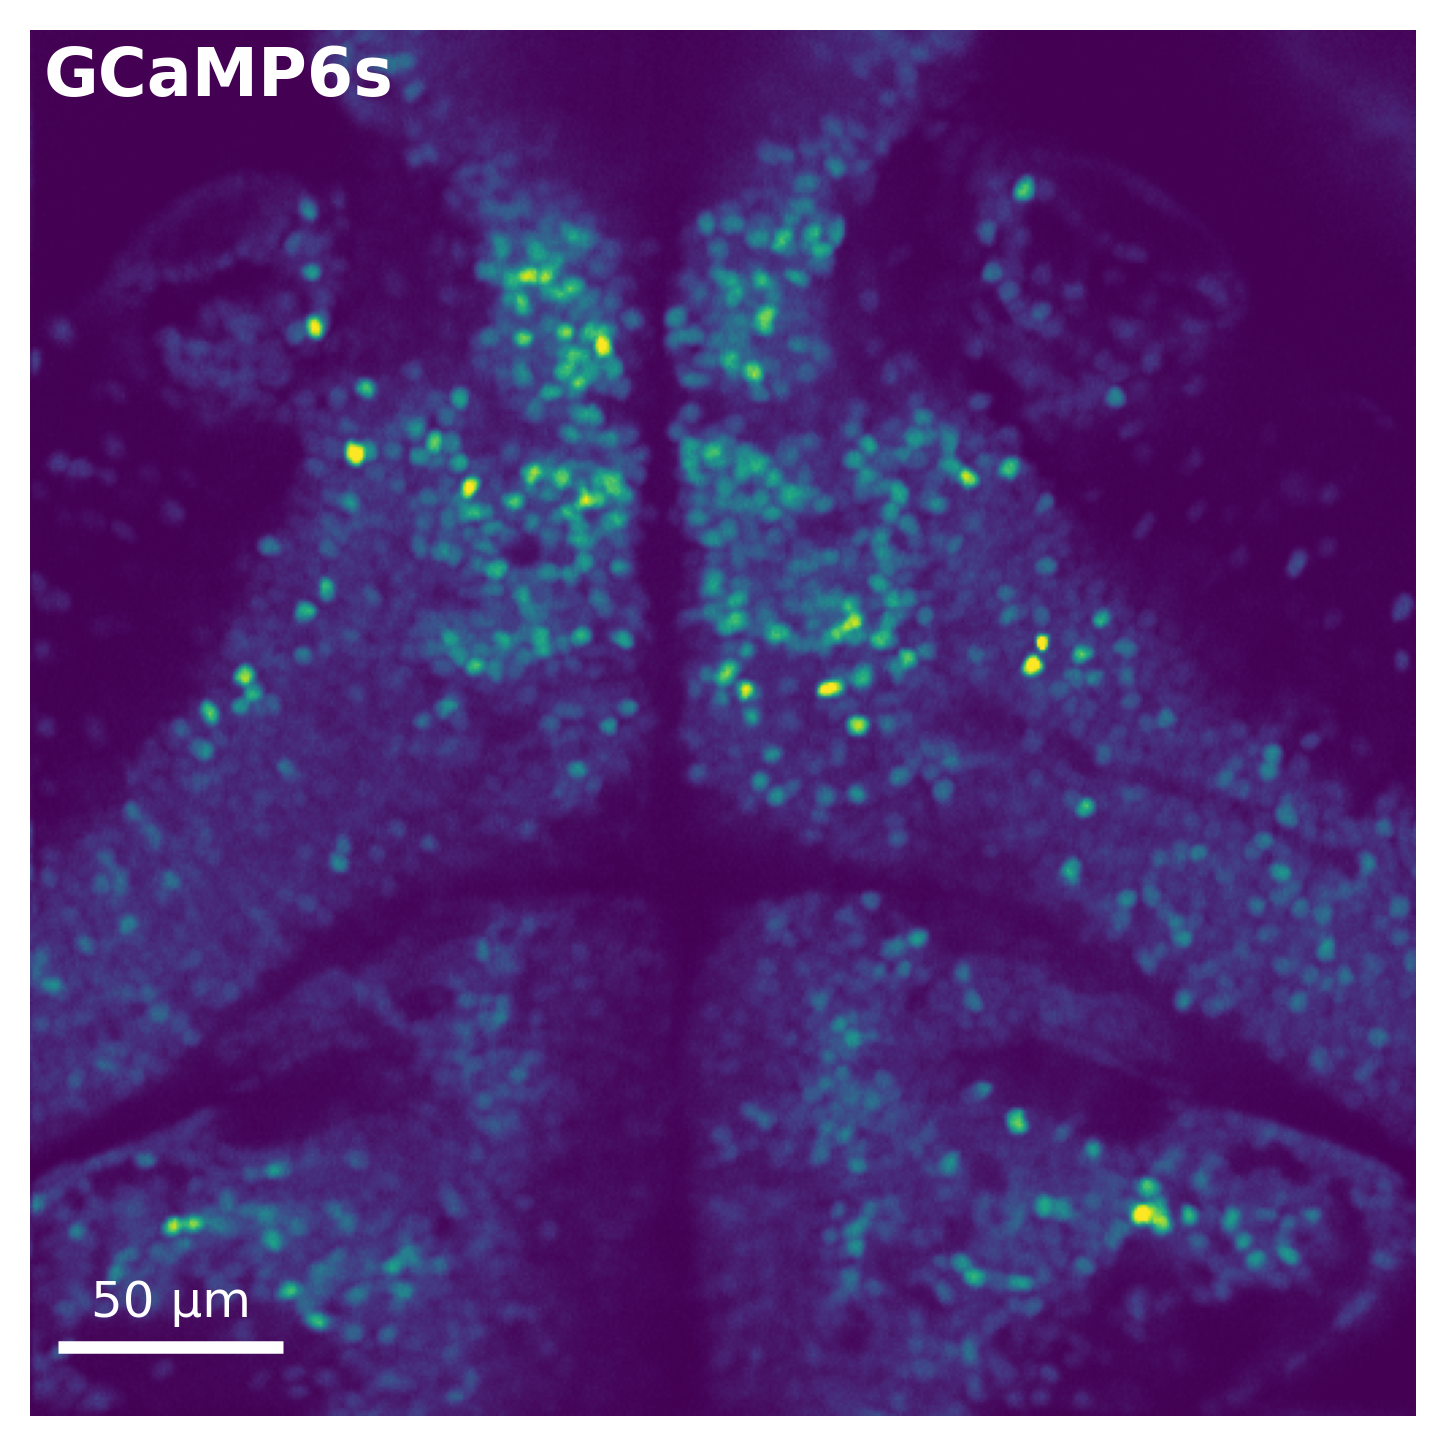

saved C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_4\fig1b_pre.pdf


In [136]:
# **the rest of this figure is drawn with Adobe Illustrator
import os
import glob
import tifffile
import numpy as np
import matplotlib.pyplot as plt

fish = 11
BASE_DIR = os.path.abspath(
    os.path.join(
        RESULTS_DIR, "experiment_4"
    )
)
img_dir = os.path.join(
        DATA_DIR, f"fish{fish}", "images"
    )

SCALE_BAR_UM =50 
UM_PER_PIXEL =0.6 
bar_len_px =SCALE_BAR_UM /UM_PER_PIXEL 
x0 ,y0 =0.02 ,0.95 

print("Looking in:", img_dir)
print("Contents:", os.listdir(img_dir))

plane0_file = glob.glob(os.path.join(img_dir, "plane_0.*"))[0]

im = tifffile.imread(plane0_file).astype(float)
im = (im - im.min()) / (im.max() - im.min())
im *= 1.5
im = np.clip(im, 0, 1)

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.imshow(im, cmap="viridis")

bar_len_px = SCALE_BAR_UM / UM_PER_PIXEL
x0, y0 = 0.02, 0.95

# convert axes fraction to data coordinates
xdata0, ydata0 = ax.transAxes.transform((x0, 1 - y0))
xdata0, ydata0 = ax.transData.inverted().transform((xdata0, ydata0))

# draw scale bar
ax.hlines(
    y=ydata0,
    xmin=xdata0,
    xmax=xdata0 + bar_len_px,
    colors="white",
    linewidth=3,
    transform=ax.transData,
    clip_on=False
)
ax.text(
    xdata0 + bar_len_px / 2,
    ydata0 - bar_len_px * 0.3,
    f"{SCALE_BAR_UM} µm",
    color="white",
    ha="center",
    va="top",
    fontsize=12
)

# label
ax.text(
    0.01,
    0.99,
    "GCaMP6s",
    transform=ax.transAxes,
    va="top",
    ha="left",
    color="white",
    weight="bold",
    fontsize=16
)

ax.axis("off")

out = os.path.join(BASE_DIR, f"fig1b_pre.pdf")
fig.savefig(out, bbox_inches="tight", transparent=True)
plt.show()
plt.close(fig)
print("saved", out)

## Figure 1c

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_1\fig1c.pdf


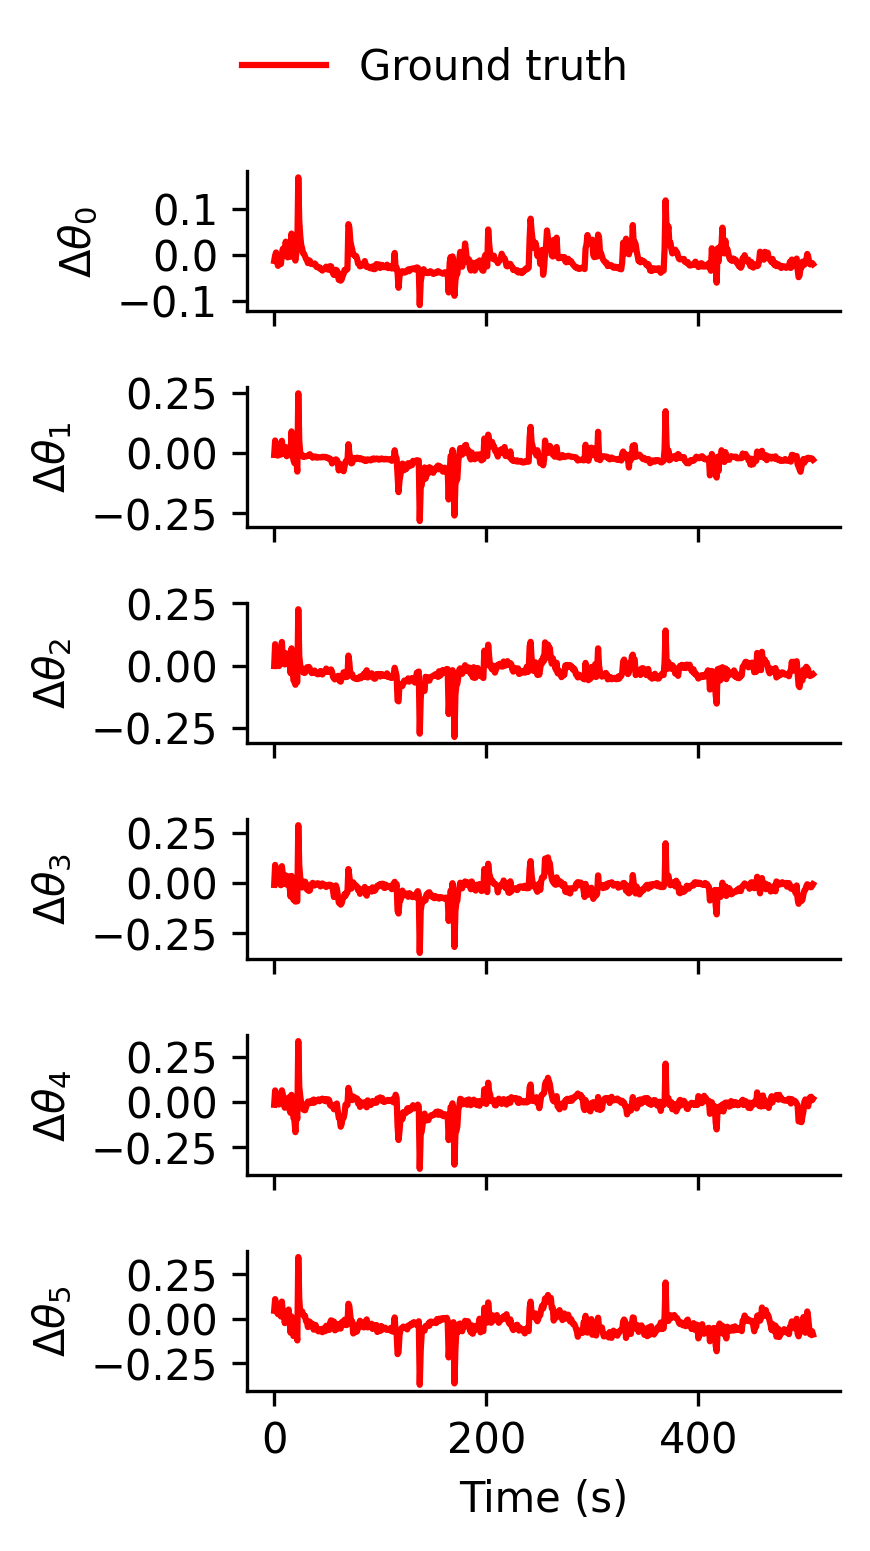

In [120]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

fish = 11
seq = 10
use_components = [0, 1, 2, 3, 4, 5]
num_runs = 10
models_to_use = []
panel_plot = True

width = 3.0
height_per_panel = 0.8

frame_range = None

RESULTS_ROOT = os.path.abspath(
    os.path.join(
        RESULTS_DIR, "experiment_1"
    )
)

full_model_map = {
    "GPT-2 (base)":       ("gpt2_pretrained",    "#1f77b4"),
    "LSTM":               ("lstm",               "#ff7f0e"),
    "DeepSeek-coder-7b":  ("deepseek_moe",       "#000000"),
    "BERT-small":         ("bert",               "#7f7f7f"),
}
model_map = {m: full_model_map[m] for m in models_to_use}

gt_path = os.path.join(
    RESULTS_ROOT, f"fish{fish}",
    f"fish{fish}_final_predictions_groundtruth_test.npy"
)
y_true = np.load(gt_path)
time_vec = np.arange(y_true.shape[0]) / 1.1

if frame_range is not None:
    start, end = frame_range
    y_true = y_true[start:end]
    time_vec = time_vec[start:end]

plt.rcParams["pdf.fonttype"] = 42

if panel_plot:
    baselines = {
        comp: np.mean(y_true[:50, comp])
        for comp in use_components
    }
    n = len(use_components)
    fig, axes = plt.subplots(
        n, 1, sharex=True,
        figsize=(width, height_per_panel * n),
        dpi=300
    )

    for idx, comp in enumerate(use_components):
        ax = axes[idx]
        gt_label = "Ground truth" if idx == 0 else None
        y_gt = y_true[:, comp] - baselines[comp]
        ax.plot(time_vec, y_gt, color="red", lw=1.5, label=gt_label)

        for model_name, (key, color) in model_map.items():
            runs = []
            for run in range(1, num_runs + 1):
                fpath = os.path.join(
                    RESULTS_ROOT,
                    f"fish{fish}", f"run_{run}",
                    f"seq_{seq}",
                    f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                )
                if not os.path.isfile(fpath):
                    continue
                pred = np.load(fpath)
                if frame_range is not None:
                    pred = pred[start:end]
                runs.append(pred[:, comp] - baselines[comp])

            if not runs:
                continue

            data = np.vstack(runs)
            mean_ts = data.mean(axis=0)
            sem_ts = sem(data, axis=0)
            mlabel = model_name if idx == 0 else None

            ax.plot(time_vec, mean_ts, color=color, lw=1.2, label=mlabel)
            ax.fill_between(
                time_vec,
                mean_ts - sem_ts,
                mean_ts + sem_ts,
                color=color, alpha=0.2
            )

        ax.set_ylabel(rf"$\Delta\theta_{{{comp}}}$")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        ncol=len(handles),
        frameon=False,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.0),
        bbox_transform=fig.transFigure
    )
    fig.subplots_adjust(top=0.85)
    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    out_name = f"fig1c.pdf"

else:
    y_sum_full = y_true[:, use_components].sum(axis=1)
    baseline_sum = np.mean(y_sum_full[:50])
    y_sum_shifted = y_sum_full - baseline_sum

    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)

    ax.plot(time_vec, y_sum_shifted,
            color="red", lw=1.5, label="Ground truth")

    for model_name, (key, color) in model_map.items():
        runs = []
        for run in range(1, num_runs + 1):
            fpath = os.path.join(
                RESULTS_ROOT,
                f"fish{fish}", f"run_{run}",
                f"seq_{seq}",
                f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
            )
            if not os.path.isfile(fpath):
                continue
            pred = np.load(fpath)
            if frame_range is not None:
                pred = pred[start:end]
            runs.append(pred[:, use_components].sum(axis=1) - baseline_sum)

        if not runs:
            continue

        data = np.vstack(runs)
        mean_ts = data.mean(axis=0)
        sem_ts = sem(data, axis=0)

        ax.plot(time_vec, mean_ts, color=color, lw=1.2, label=model_name)
        ax.fill_between(
            time_vec,
            mean_ts - sem_ts,
            mean_ts + sem_ts,
            color=color, alpha=0.2
        )

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta \sum_{i}\theta_i$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(ncol=1, frameon=False, loc="upper right")
    fig.tight_layout()
    out_name = f"fig1c.pdf"

out_file = os.path.join(RESULTS_ROOT, out_name)
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)


## Figure 2a

C:\Users\jacob\AppData\Local\Temp\ipykernel_29896\3297774121.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved -> C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_1\fig2a.pdf


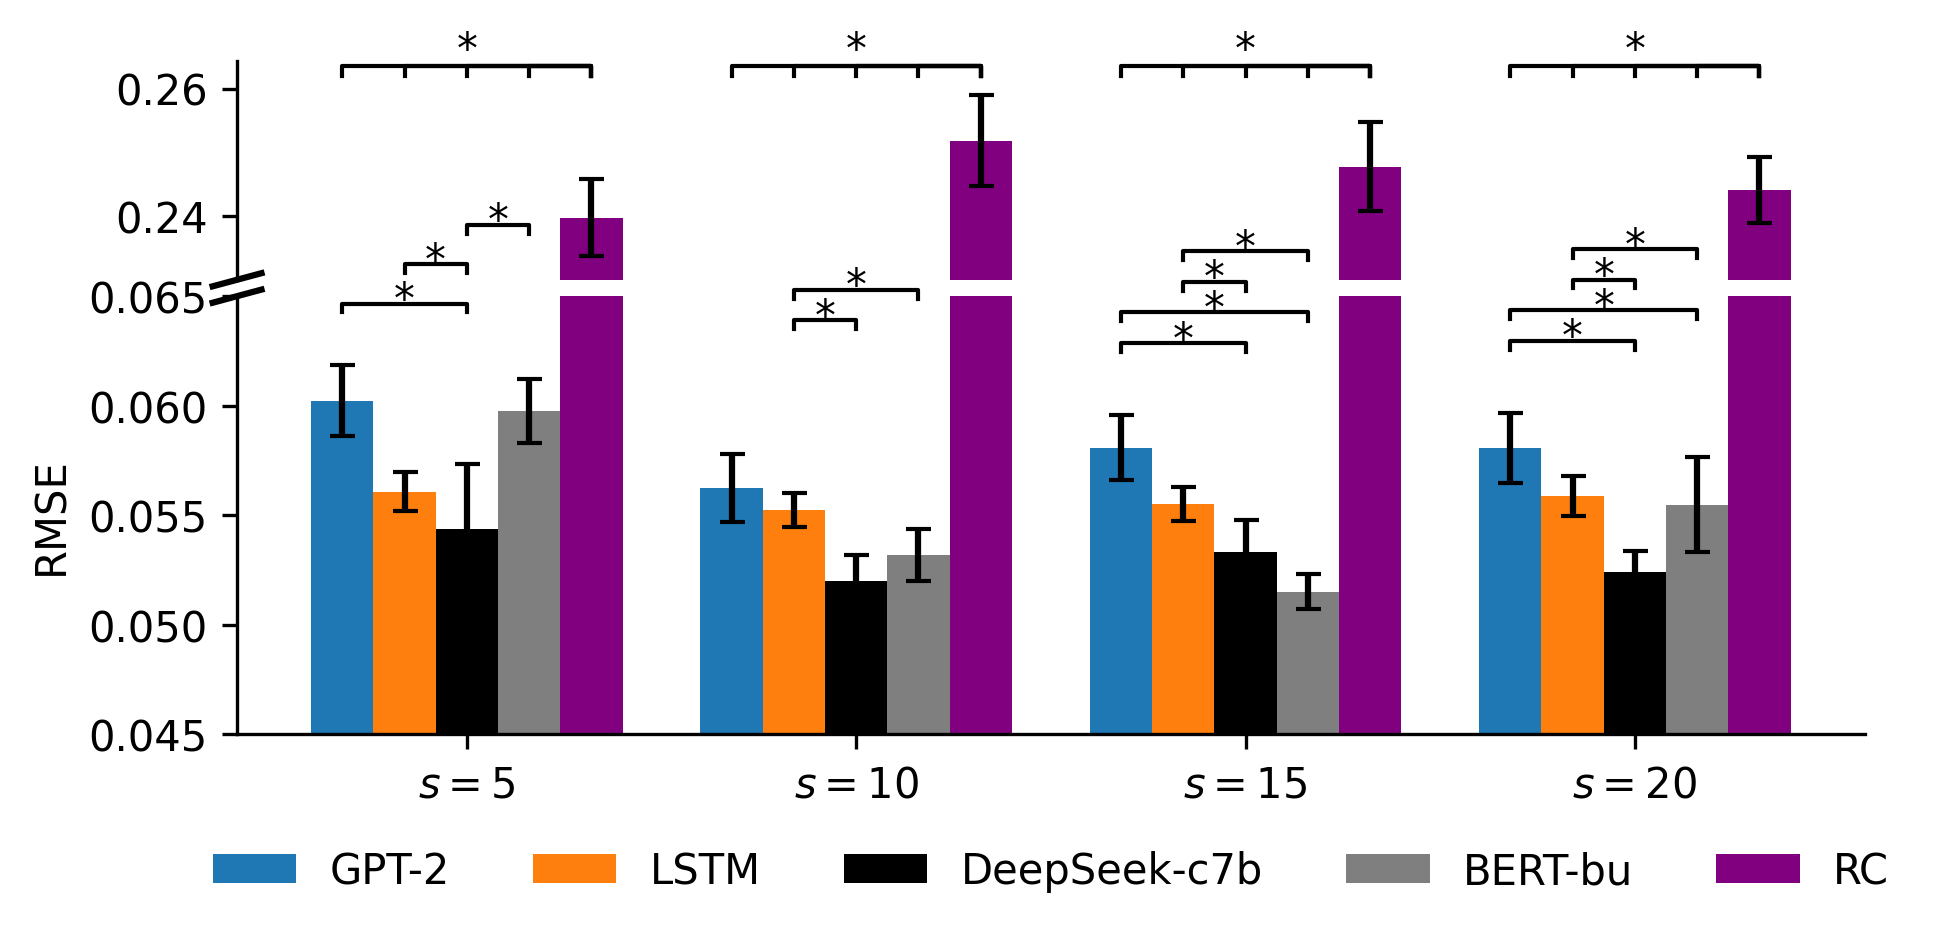

In [112]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem
from itertools import combinations
from pathlib import Path
from config import RESULTS_DIR

PRINT_PVALS = False

RESULTS_ROOT = Path(RESULTS_DIR) / "experiment_1"
fish_list    = [9, 10, 11, 12, 13]
seq_lengths  = [5, 10, 15, 20]
num_runs     = 10

model_map = {
    "GPT-2 (base)":      ("gpt2_pretrained", "#1f77b4", "GPT-2"),
    "LSTM":              ("lstm",            "#ff7f0e", "LSTM"),
    "DeepSeek-coder-7b": ("deepseek_moe",    "#000000", "DeepSeek-c7b"),
    "BERT-small":        ("bert",            "#7f7f7f", "BERT-bu"),
    "RC":                ("reservoir",       "purple",  "RC"),
}
model_names = list(model_map)
non_rc      = [m for m in model_names if m != "RC"]

# ───────── load RMSE data ─────────
rmse_data = {m: {s: [] for s in seq_lengths} for m in model_names}
for fish in fish_list:
    y_true = np.load(
        RESULTS_ROOT / f"fish{fish}" /
        f"fish{fish}_final_predictions_groundtruth_test.npy"
    )
    for run in range(1, num_runs+1):
        for s in seq_lengths:
            sd = RESULTS_ROOT / f"fish{fish}" / f"run_{run}" / f"seq_{s}"
            if not sd.is_dir():
                continue
            for m in model_names:
                key = model_map[m][0]
                fp  = sd / f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                if fp.is_file():
                    preds = np.load(fp)
                    rmse  = np.sqrt(((preds - y_true)**2).mean())
                    rmse_data[m][s].append(rmse)

means = {m: [np.mean(rmse_data[m][s]) for s in seq_lengths] for m in model_names}
errs  = {m: [sem(rmse_data[m][s]) for s in seq_lengths] for m in model_names}

# ───────── compute p-values ─────────
pairs_lo = list(combinations(non_rc, 2))        # all non-RC vs non-RC
pairs_hi = [("RC", m) for m in non_rc]          # RC vs each other

pvals = {s: {} for s in seq_lengths}
for s in seq_lengths:
    for (m1, m2) in pairs_lo + pairs_hi:
        p = mannwhitneyu(rmse_data[m1][s], rmse_data[m2][s])[1]
        pvals[s][(m1, m2)] = p

if PRINT_PVALS:
    print("P-values by sequence length:")
    for s in seq_lengths:
        print(f" s = {s}")
        for (m1, m2), p in pvals[s].items():
            print(f"   {m1:15s} vs {m2:15s}: p = {p:.4f}")
    print()

# ───────── plot setup ─────────
plt.rcParams["pdf.fonttype"] = 42
fig, (ax_hi, ax_lo) = plt.subplots(
    2, 1, sharex=True, figsize=(7, 3.4), dpi=300,
    gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05}
)

x  = np.arange(len(seq_lengths))
bw = 0.8 / len(model_names)

# bars
for i, m in enumerate(model_names):
    off = (i - len(model_names)/2)*bw + bw/2
    col, lbl = model_map[m][1:]
    ax_lo.bar(x+off, means[m], width=bw,
              yerr=None if m=="RC" else errs[m],
              capsize=0 if m=="RC" else 3,
              color=col, label=lbl)
    if m == "RC":
        ax_hi.bar(x+off, means[m], width=bw,
                  yerr=errs[m], capsize=3,
                  color=col, label="_nolegend_")

# axis limits
ax_lo.set_ylim(0.045, 0.065)
ax_hi.set_ylim(0.23, None)

# clean spines/ticks
for ax in (ax_hi, ax_lo):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
ax_hi.spines["bottom"].set_visible(False)
ax_hi.tick_params(axis="x", bottom=False, labelbottom=False)

# broken-axis slashes
d = 0.015
ax_lo.plot((-d, +d), (1-d, 1+d), transform=ax_lo.transAxes,
           color="k", clip_on=False)
ax_hi.plot((-d, +d), (-2*d, +2*d), transform=ax_hi.transAxes,
           color="k", clip_on=False)

ax_lo.set_ylabel("RMSE")
ax_lo.set_xticks(x)
ax_lo.set_xticklabels([f"$s={s}$" for s in seq_lengths])

# ───────── bracket parameters ─────────
h_lo          = 0.0004      # lower bracket height
h_hi          = 0.0016       # upper bracket height
sep_def       = 0.001       # default lower separation
sep_s5        = 0.0005      # tighter sep at s=5
star_off      = -0.0008     # star offset
gap_lo        = 0.0015      # gap above non-RC bars
gap_hi        = 0.01        # gap above RC bars
RC_SHIFT_DOWN = 0.007       # how much to drop the RC brackets

# ───────── draw lower brackets ─────────
for j, s in enumerate(seq_lengths):
    top_nonrc = max(means[m][j] + errs[m][j] for m in non_rc)
    y0 = top_nonrc + gap_lo
    sep = sep_s5 if s == 5 else sep_def
    for idx, (m1, m2) in enumerate(pairs_lo):
        x1 = x[j] + ((model_names.index(m1) - len(model_names)/2)*bw + bw/2)
        x2 = x[j] + ((model_names.index(m2) - len(model_names)/2)*bw + bw/2)
        y  = y0 + idx*(h_lo + sep)
        if pvals[s][(m1, m2)] < 0.05:
            ax_lo.plot([x1, x1, x2, x2],
                       [y, y+h_lo, y+h_lo, y],
                       lw=1, c="k", clip_on=False)
            ax_lo.text((x1+x2)/2, y+h_lo+star_off,
                       "*", ha="center", va="bottom",
                       fontsize=10, clip_on=False)

# ───────── draw RC vs all (upper) ─────────
top_rc = max(means["RC"][j] + errs["RC"][j] for j in range(len(seq_lengths)))
y0_hi = top_rc + gap_hi - RC_SHIFT_DOWN
ax_hi.set_ylim(0.23, y0_hi + h_hi + abs(star_off))

for j, s in enumerate(seq_lengths):
    for (m1, m2) in pairs_hi:
        x1 = x[j] + ((model_names.index(m1) - len(model_names)/2)*bw + bw/2)
        x2 = x[j] + ((model_names.index(m2) - len(model_names)/2)*bw + bw/2)
        # bracket
        ax_hi.plot([x1, x1, x2, x2],
                   [y0_hi, y0_hi+h_hi, y0_hi+h_hi, y0_hi],
                   lw=1, c="k", clip_on=False)
        # star only for GPT-2 comparison
        if m2 == "GPT-2 (base)" and pvals[s][(m1, m2)] < 0.05:
            ax_hi.text((x1+x2)/2, y0_hi+h_hi+star_off,
                       "*", ha="center", va="bottom",
                       fontsize=10, clip_on=False)

# ───────── finalize ─────────
ax_lo.legend(ncol=len(model_names), frameon=False,
             loc="upper center", bbox_to_anchor=(0.5, -0.18))
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()

out_path = RESULTS_ROOT / "fig2a.pdf"
plt.savefig(out_path, bbox_inches="tight")
print("Saved ->", out_path)


## Figure 2b

Saved -> C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_2\fig2b.pdf


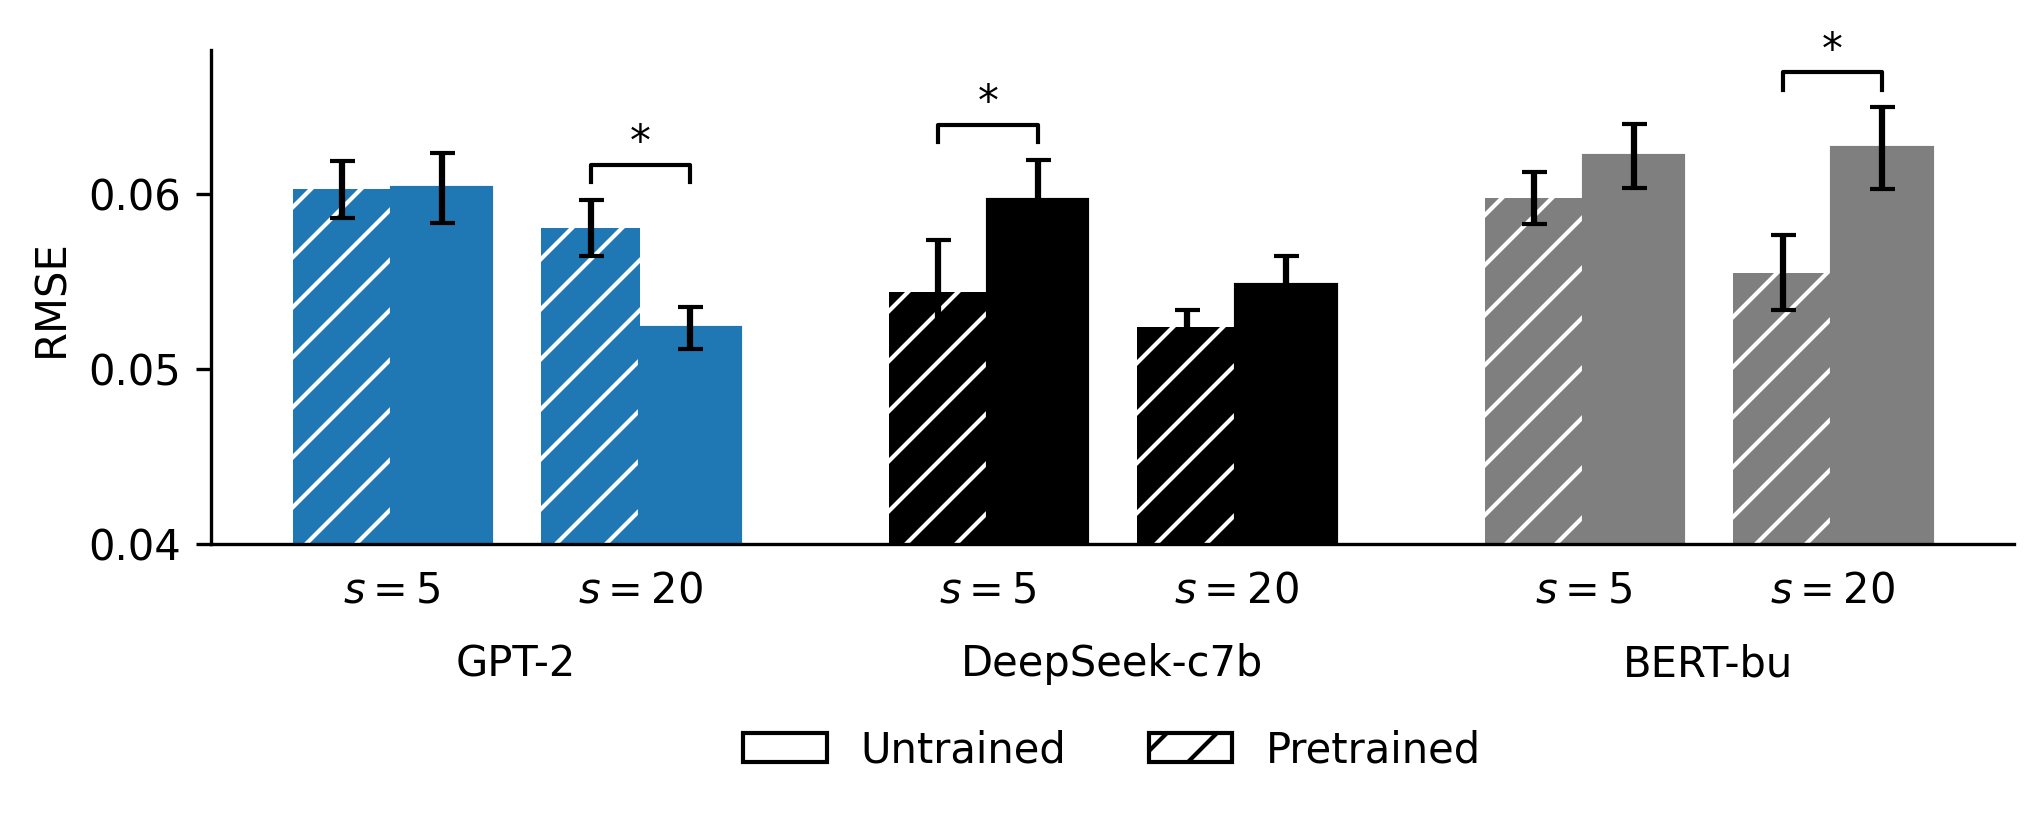

In [119]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.patches as mpatches
from scipy.stats import wilcoxon, sem
from pathlib import Path
from config import RESULTS_DIR

EXP1_ROOT = Path(RESULTS_DIR) / "experiment_1"
EXP2_ROOT = Path(RESULTS_DIR) / "experiment_2"

fish_list   = [9, 10, 11, 12, 13]
seq_lengths = [5, 20]

model_info = {
    "GPT-2":      {"pre_key": "gpt2_pretrained", "stub": "GPT2",     "c": "#1f77b4"},
    "DeepSeek-c7b": {"pre_key": "deepseek_moe",    "stub": "DeepSeek", "c": "#000000"},
    "BERT-bu":        {"pre_key": "bert",            "stub": "BERT",     "c": "#7f7f7f"},
}
states = {"prtr": "Pretrained", "untr": "Untrained"}

def load_gt(fid):
    for root in (EXP1_ROOT, EXP2_ROOT):
        for cand in (f"fish{fid}_test_groundtruth.npy", f"fish{fid}_groundtruth_test.npy"):
            p = root / cand
            if p.is_file(): return np.load(p)
        sub = root / f"fish{fid}"
        for cand in (f"fish{fid}_test_groundtruth.npy", f"fish{fid}_groundtruth_test.npy"):
            p = sub / cand
            if p.is_file(): return np.load(p)
    raise FileNotFoundError(f"GT fish{fid}")

rmse = {s:{m:{"prtr":[], "untr":[]} for m in model_info} for s in seq_lengths}

for fish in fish_list:
    y_true = load_gt(fish)
    for run in range(1,11):
        for s in seq_lengths:
            d = EXP1_ROOT / f"fish{fish}" / f"run_{run}" / f"seq_{s}"
            if d.is_dir():
                for m,meta in model_info.items():
                    p = d / f"fish{fish}_final_predictions_{meta['pre_key']}_test_run{run}.npy"
                    if p.is_file():
                        preds = np.load(p)
                        rmse[s][m]["prtr"].append(np.sqrt(((preds-y_true)**2).mean()))
    for run in range(1,11):
        for s in seq_lengths:
            for m,meta in model_info.items():
                p = EXP2_ROOT / f"fish{fish}_model_{meta['stub']}_Untrained_run{run}_seq{s}_test_preds.npy"
                if p.is_file():
                    preds = np.load(p)
                    rmse[s][m]["untr"].append(np.sqrt(((preds-y_true)**2).mean()))

means, errs, pvals = {}, {}, {}
for s in seq_lengths:
    means[s], errs[s], pvals[s] = {}, {}, {}
    for m in model_info:
        a = np.array(rmse[s][m]["prtr"]); b = np.array(rmse[s][m]["untr"])
        means[s][(m,"prtr")] = a.mean() if a.size else np.nan
        errs [s][(m,"prtr")] = sem(a)   if a.size>1 else 0
        means[s][(m,"untr")] = b.mean() if b.size else np.nan
        errs [s][(m,"untr")] = sem(b)   if b.size>1 else 0
        pvals[s][m] = wilcoxon(a,b).pvalue if a.size==b.size and a.size else np.nan

plt.rcParams["pdf.fonttype"] = 42
fig,ax=plt.subplots(figsize=(7,3),dpi=300)

bw = 0.2
gap = 0.05
offs = (np.array([-1.5,-0.5,0.5,1.5])*bw)+np.array([-gap,-gap,gap,gap])
model_names=list(model_info)
centers=np.arange(len(model_names))*((offs.max()-offs.min())+0.5)

seen=set()
for i,m in enumerate(model_names):
    c0=centers[i]
    for j,s in enumerate(seq_lengths):
        for k,st in enumerate(["prtr","untr"]):
            x=c0+offs[j*2+k]
            val=means[s][(m,st)]; err=errs[s][(m,st)]
            if np.isnan(val): continue
            col=model_info[m]["c"]
            hatch,edge,lw = ("//","white",0) if st=="prtr" else ("",col,1)
            lbl=None
            if (m,st) not in seen:
                lbl=f"{m} {states[st]}"; seen.add((m,st))
            ax.bar(x,val,width=bw,yerr=err,capsize=3,color=col,edgecolor=edge,linewidth=lw,hatch=hatch,label=lbl)

ax.set_xticks([])
for i,m in enumerate(model_names):
    c=centers[i]
    ax.text(c+offs[:2].mean(),-0.05,r"$s=5$",ha="center",va="top",transform=ax.get_xaxis_transform())
    ax.text(c+offs[2:].mean(),-0.05,r"$s=20$",ha="center",va="top",transform=ax.get_xaxis_transform())
    ax.text(c,-0.20,m,ha="center",va="top",transform=ax.get_xaxis_transform())

ax.set_ylabel("RMSE")
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
ax.set_ylim(0.04,None)

styles=[
    mpatches.Patch(facecolor='white',edgecolor='black',label='Untrained'),
    mpatches.Patch(facecolor='white',edgecolor='black',hatch='//',label='Pretrained')
]
ax.legend(styles,[h.get_label() for h in styles],ncol=2,frameon=False,
          bbox_to_anchor=(0.5,-0.3),loc='upper center')

def br(x1,x2,y,h): ax.plot([x1,x1,x2,x2],[y,y+h,y+h,y],c="k",lw=1); ax.text((x1+x2)/2,y+h*1.05,"*",ha="center",va="bottom")
h_br=0.001
for i,m in enumerate(model_names):
    c=centers[i]
    for j,s in enumerate(seq_lengths):
        if pvals[s][m]<0.05:
            top=max(means[s][(m,"prtr")]+errs[s][(m,"prtr")],means[s][(m,"untr")]+errs[s][(m,"untr")])
            br(c+offs[j*2],c+offs[j*2+1],top+h_br,h_br)

plt.tight_layout()
out=EXP2_ROOT/"fig2b.pdf"
plt.savefig(out,dpi=300,transparent=True,bbox_inches="tight")
print("Saved ->",out)

## Figure 2c

Saved -> C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_1\fig2c.pdf


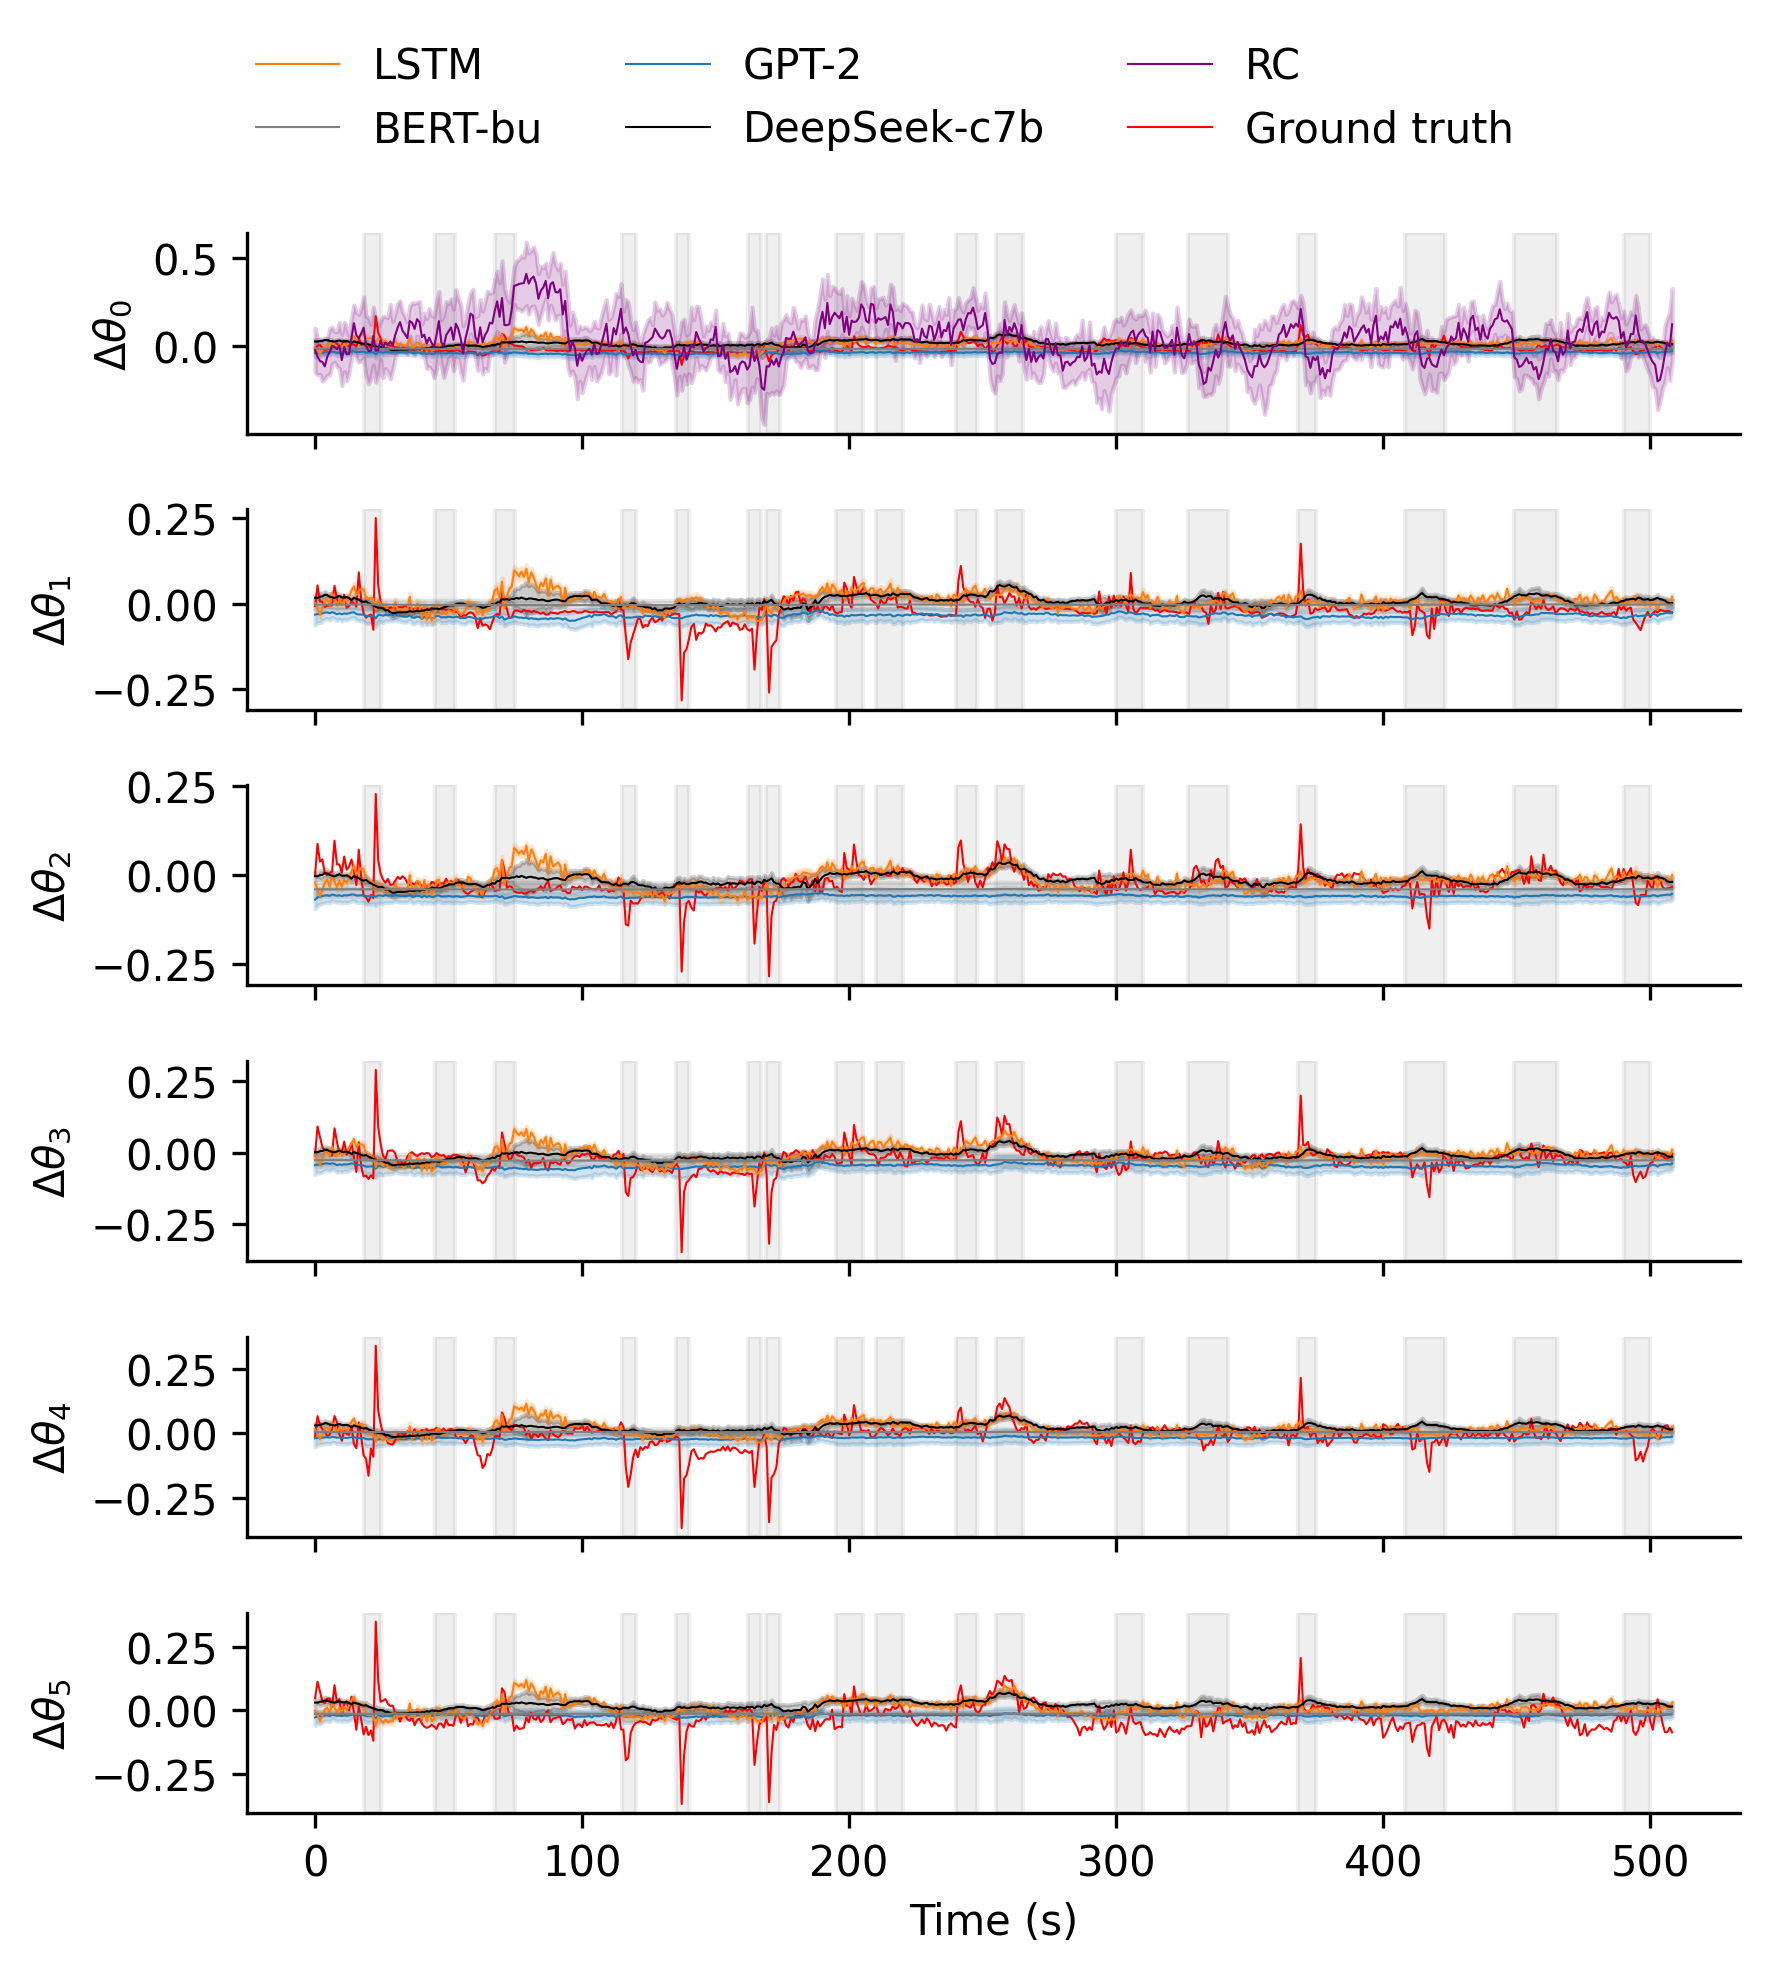

In [118]:
import os, numpy as np, matplotlib.pyplot as plt
from scipy.stats import sem, t
from pathlib import Path
from config import RESULTS_DIR

fish, seq = 11, 10
use_components = [0, 1, 2, 3, 4, 5]
num_runs, single_run = 10, None
panel_plot, reservoir_in_legend = True, True
sampling_rate_hz, frame_range = 1.1, None
width, height_per_panel = 6, 1

models = [
    "GPT-2", "LSTM", "DeepSeek-c7b",
    "BERT-bu", "RC"
]
palette = {
    "GPT-2":      ("gpt2_pretrained", "#1f77b4"),
    "LSTM":              ("lstm",            "#ff7f0e"),
    "DeepSeek-c7b": ("deepseek_moe",    "#000000"),
    "BERT-bu":        ("bert",            "#7f7f7f"),
    "RC":("reservoir",       "purple"),
}
model_map = {m: palette[m] for m in models}

EVENTS = [
    (18.3, 24.7), (45.0, 52.5), (67.2, 75.0), (115,120), (135,140),
    (162,167), (169,174), (195,205), (210,220), (240,248), (255,265),
    (300,310), (327,342), (368,375), (408,423), (449,465), (490,500)
]
shade_events, EVENT_COLOR, EVENT_ALPHA = True, "gray", 0.12

ROOT = Path(RESULTS_DIR) / "experiment_1"
gt = np.load(ROOT / f"fish{fish}" / f"fish{fish}_final_predictions_groundtruth_test.npy")
if frame_range: gt = gt[frame_range[0]:frame_range[1]]
tvec = np.arange(len(gt)) / sampling_rate_hz
baselines = {c: gt[:50, c].mean() for c in use_components}
plt.rcParams["pdf.fonttype"] = 42

def runs(): return [single_run] if single_run else range(1, num_runs+1)

def load(key, comp_slice):
    arrs = []
    for run in runs():
        f = ROOT / f"fish{fish}" / f"run_{run}" / f"seq_{seq}" / f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
        if not f.exists(): continue
        a = np.load(f)
        if frame_range: a = a[frame_range[0]:frame_range[1]]
        arrs.append(a[:, comp_slice])
    return np.stack(arrs) if arrs else None

def mean_ci(arr, axis=0):
    m = arr.mean(axis=axis)
    s = sem(arr, axis=axis)
    df = arr.shape[axis]-1
    mult = t.ppf(0.975, df=df) if df>0 else 0
    return m, mult*s

if panel_plot:
    n = len(use_components)
    fig, axs = plt.subplots(n, 1, sharex=True, figsize=(width, height_per_panel*n), dpi=300)
    for i, comp in enumerate(use_components):
        ax = axs[i]
        if shade_events:
            for s,e in EVENTS: ax.axvspan(s, e, color=EVENT_COLOR, alpha=EVENT_ALPHA, zorder=0)
        ax.plot(tvec, gt[:, comp]-baselines[comp], color="red", lw=0.5, label="Ground truth" if i==0 else None)
        for name,(key,col) in model_map.items():
            if name=="RC" and i>0: continue
            dat = load(key, comp)
            if dat is None: continue
            mu, ci = mean_ci(dat)
            ax.plot(tvec, mu-baselines[comp], color=col, lw=0.5, label=name if i==0 else None)
            ax.fill_between(tvec, mu-ci-baselines[comp], mu+ci-baselines[comp], color=col, alpha=0.2)
        ax.set_ylabel(fr"$\Delta\theta_{{{comp}}}$"); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    h,l = axs[0].get_legend_handles_labels(); d=dict(zip(l,h))
    order = ["LSTM","BERT-bu","GPT-2","DeepSeek-c7b"] + (["RC"] if reservoir_in_legend else [])
    handles = [d[o] for o in order] + [d["Ground truth"]]
    fig.legend(handles, order+["Ground truth"], ncol=3, frameon=False, loc="lower center",
               bbox_to_anchor=(0.5,1.0), bbox_transform=fig.transFigure)
    fig.subplots_adjust(top=0.85); axs[-1].set_xlabel("Time (s)")
    out = f"fig2c.pdf"
else:
    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)
    if shade_events:
        for s,e in EVENTS: ax.axvspan(s, e, color=EVENT_COLOR, alpha=EVENT_ALPHA, zorder=0)
    ysum = gt[:, use_components].sum(1); base = ysum[:50].mean()
    ax.plot(tvec, ysum-base, color="red", lw=1, label="Ground truth")
    for name,(key,col) in model_map.items():
        dat = load(key, slice(None))
        if dat is None: continue
        dat = dat[..., use_components].sum(-1)
        mu, ci = mean_ci(dat)
        ax.plot(tvec, mu-base, color=col, lw=0.8, label=name)
        ax.fill_between(tvec, mu-ci-base, mu+ci-base, color=col, alpha=0.2)
    ax.set_xlabel("Time (s)"); ax.set_ylabel(r"$\Delta \sum_i\theta_i$")
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(ncol=3, frameon=False, loc="upper right")
    out = f"tail_sum_fish{fish}_s{seq}_baseline.pdf"

fig.tight_layout()
out_path = ROOT / out
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved ->", out_path)


## Figure 3

Figure saved to: C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_3\fig3.pdf


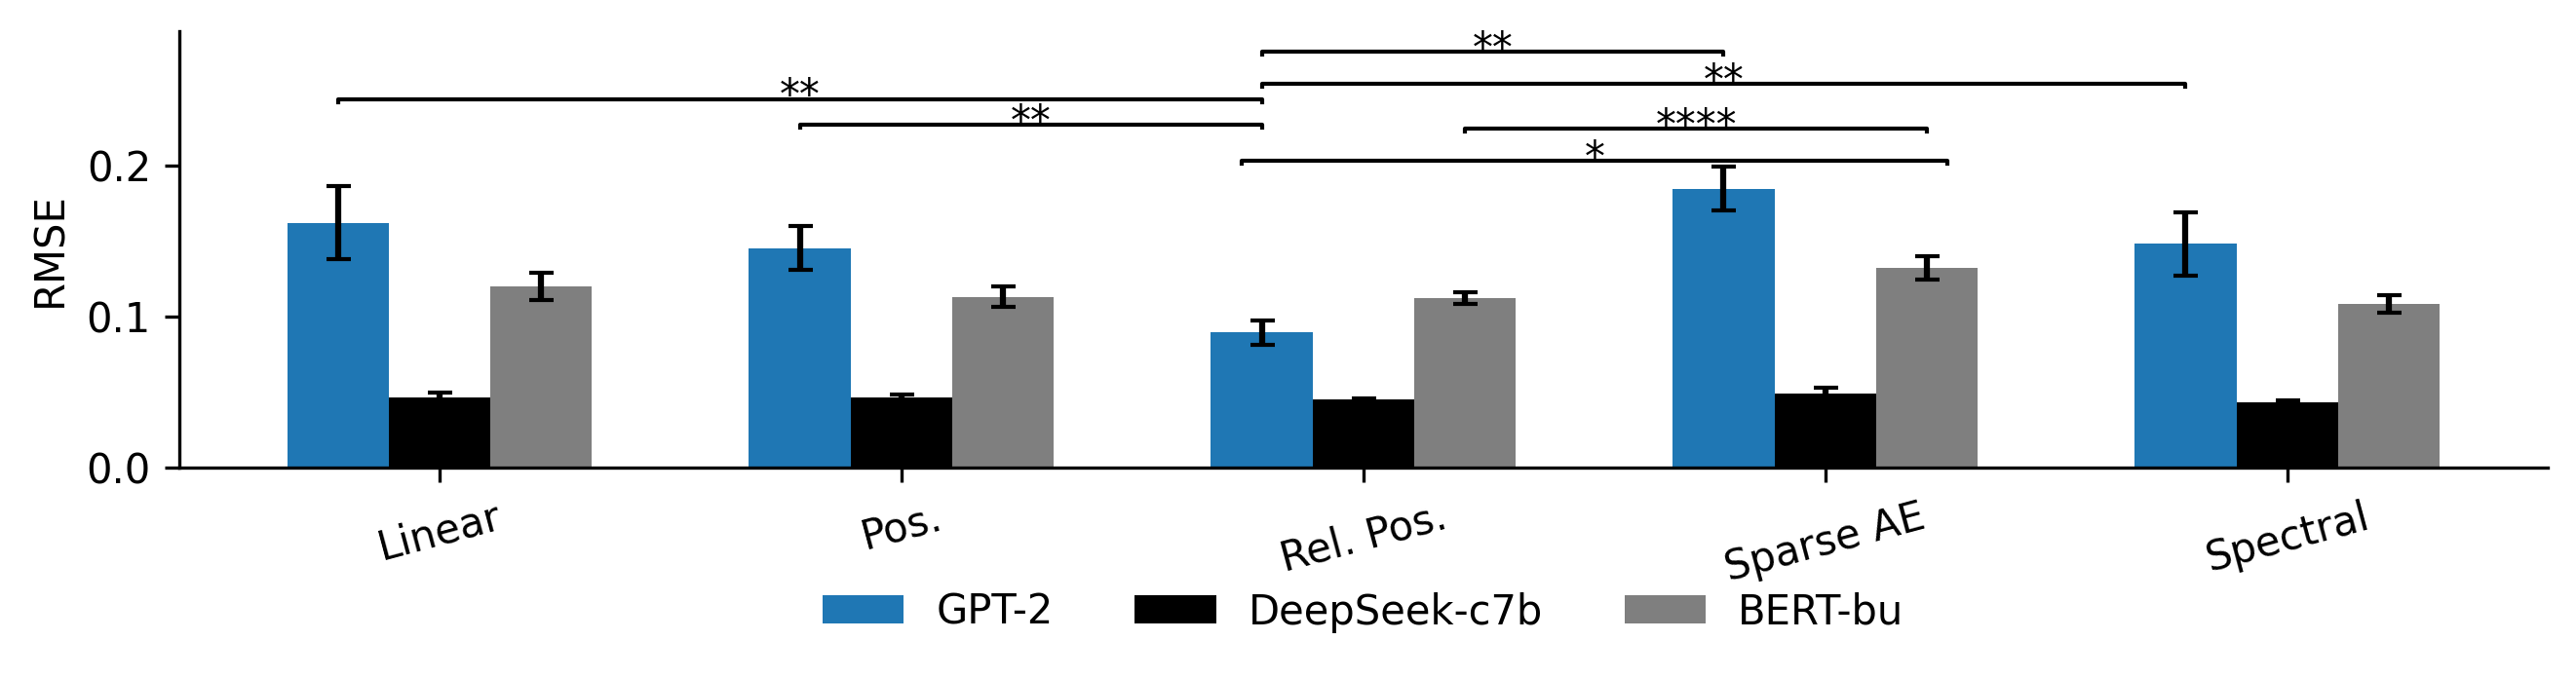

In [53]:
import os, re, itertools, numpy as np, matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem
from pathlib import Path
from config import RESULTS_DIR

# Paths
OUTDIR  = Path(RESULTS_DIR) / "experiment_3"
LOGFILE = OUTDIR / "salient_random_logs.txt"

# Settings
EMBEDS        = ["Vanilla", "Positional", "RelativePos", "Sparse", "Spectral"]
MODELS        = ["gpt2", "deepseek", "bert"]
COLORS        = {"gpt2":"#1f77b4", "deepseek":"#000000", "bert":"#7f7f7f"}
DISPLAY       = {"gpt2":"GPT-2", "deepseek":"DeepSeek-c7b", "bert":"BERT-bu"}
COND_TO_PLOT  = "random"
alpha         = 0.05
bw            = 0.22

# Parse logfile
cond_pat    = re.compile(r"(salient50_removed|random50_removed)")
arrow_pat   = re.compile(r"^\s*([A-Za-z0-9]+)\s+\+\s+([A-Za-z0-9]+)")
summary_pat = re.compile(r"^\s+RMSE\s+([0-9.]+)$")

by_mod = {c:{e:{m:[] for m in MODELS} for e in EMBEDS} for c in ("salient","random")}
cur_c = cur_m = cur_e = None
with open(LOGFILE) as f:
    for ln in f:
        if (m:=cond_pat.search(ln)):
            cur_c = "salient" if "salient" in m.group(1) else "random"
            continue
        if (m:=arrow_pat.search(ln)):
            cur_m = m.group(1).lower()
            raw_e = m.group(2)
            cur_e = "RelativePos" if raw_e.lower()=="relativepos" else raw_e.capitalize()
            continue
        if (m:=summary_pat.match(ln)) and cur_c and cur_m and cur_e:
            by_mod[cur_c][cur_e][cur_m].append(float(m.group(1)))

# Compute means and errors
means = np.array([[np.mean(by_mod[COND_TO_PLOT][e][m]) for m in MODELS] for e in EMBEDS])
errs  = np.array([[sem   (by_mod[COND_TO_PLOT][e][m]) for m in MODELS] for e in EMBEDS])

# Pooled comparisons
pooled    = {e: sum((by_mod[COND_TO_PLOT][e][m] for m in MODELS), []) for e in EMBEDS}
pair_pvals= {}
for i,j in itertools.combinations(range(len(EMBEDS)), 2):
    _, p = mannwhitneyu(pooled[EMBEDS[i]], pooled[EMBEDS[j]], alternative="two-sided")
    pair_pvals[(i,j)] = p

# Plot bars
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(9,2.5), dpi=300)
x = np.arange(len(EMBEDS))
for mi, model in enumerate(MODELS):
    xs = x + (mi - 1) * bw
    ax.bar(xs, means[:,mi], yerr=errs[:,mi], width=bw,
           color=COLORS[model], capsize=3, label=DISPLAY[model])

ax.set_xticks(x)
ax.set_xticklabels(["Linear","Pos.","Rel. Pos.","Sparse AE","Spectral"], rotation=15)
ax.set_ylabel("RMSE")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(ncol=3, frameon=False, loc="upper center", bbox_to_anchor=(0.5,-0.20))

# Significance brackets (original logic)
h        = 0.002
pad      = -h * 6
stack_sep= h * 4.5

tops_emb    = [max(means[i] + errs[i]) for i in range(len(EMBEDS))]
pooled_stack= 0

for (i, j), p in pair_pvals.items():
    if p < alpha:
        y0 = max(tops_emb[i], tops_emb[j])
        y  = y0 + h + pooled_stack * stack_sep
        x0 = i - 1.2 * bw
        x1 = j + 1.2 * bw
        ax.plot([x0, x0, x1, x1], [y, y+h, y+h, y], color="k", lw=1)
        ax.text((x0+x1)/2, y+h+pad, "*", ha="center", va="bottom", color="k")
        pooled_stack += 1

base_offset     = pooled_stack + 5
stacks_by_model = {m_idx: 0 for m_idx in range(len(MODELS))}
star_map        = {0: "**", 1: "***", 2: "****"}

for m_idx, model in enumerate(MODELS):
    for i, j in itertools.combinations(range(len(EMBEDS)), 2):
        data_i = by_mod[COND_TO_PLOT][EMBEDS[i]][model]
        data_j = by_mod[COND_TO_PLOT][EMBEDS[j]][model]
        _, p = mannwhitneyu(data_i, data_j, alternative="two-sided")
        if p < alpha:
            x0 = i + (m_idx - 1) * bw
            x1 = j + (m_idx - 1) * bw
            top_i = means[i, m_idx] + errs[i, m_idx]
            top_j = means[j, m_idx] + errs[j, m_idx]
            y0 = max(top_i, top_j)
            model_base = base_offset + (m_idx * 1.5)
            offset     = model_base + stacks_by_model[m_idx]
            y = y0 + h + offset * stack_sep
            ax.plot([x0, x0, x1, x1], [y, y+h, y+h, y], color="k", lw=1)
            ax.text((x0+x1)/2, y+h+pad, star_map[m_idx], ha="center", va="bottom", color="k")
            stacks_by_model[m_idx] += 1

plt.tight_layout()
out_pdf = OUTDIR / "fig3.pdf"
plt.savefig(out_pdf, dpi=300, transparent=True, bbox_inches="tight")
print("Figure saved to:", out_pdf)


## Figure 4a

In [131]:
fish = 11
BASE_DIR = os.path.abspath(
    os.path.join(
        RESULTS_DIR, "experiment_4"
    )
)
img_dir = os.path.join(
        DATA_DIR, f"fish{fish}", "images"
    )

C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_6


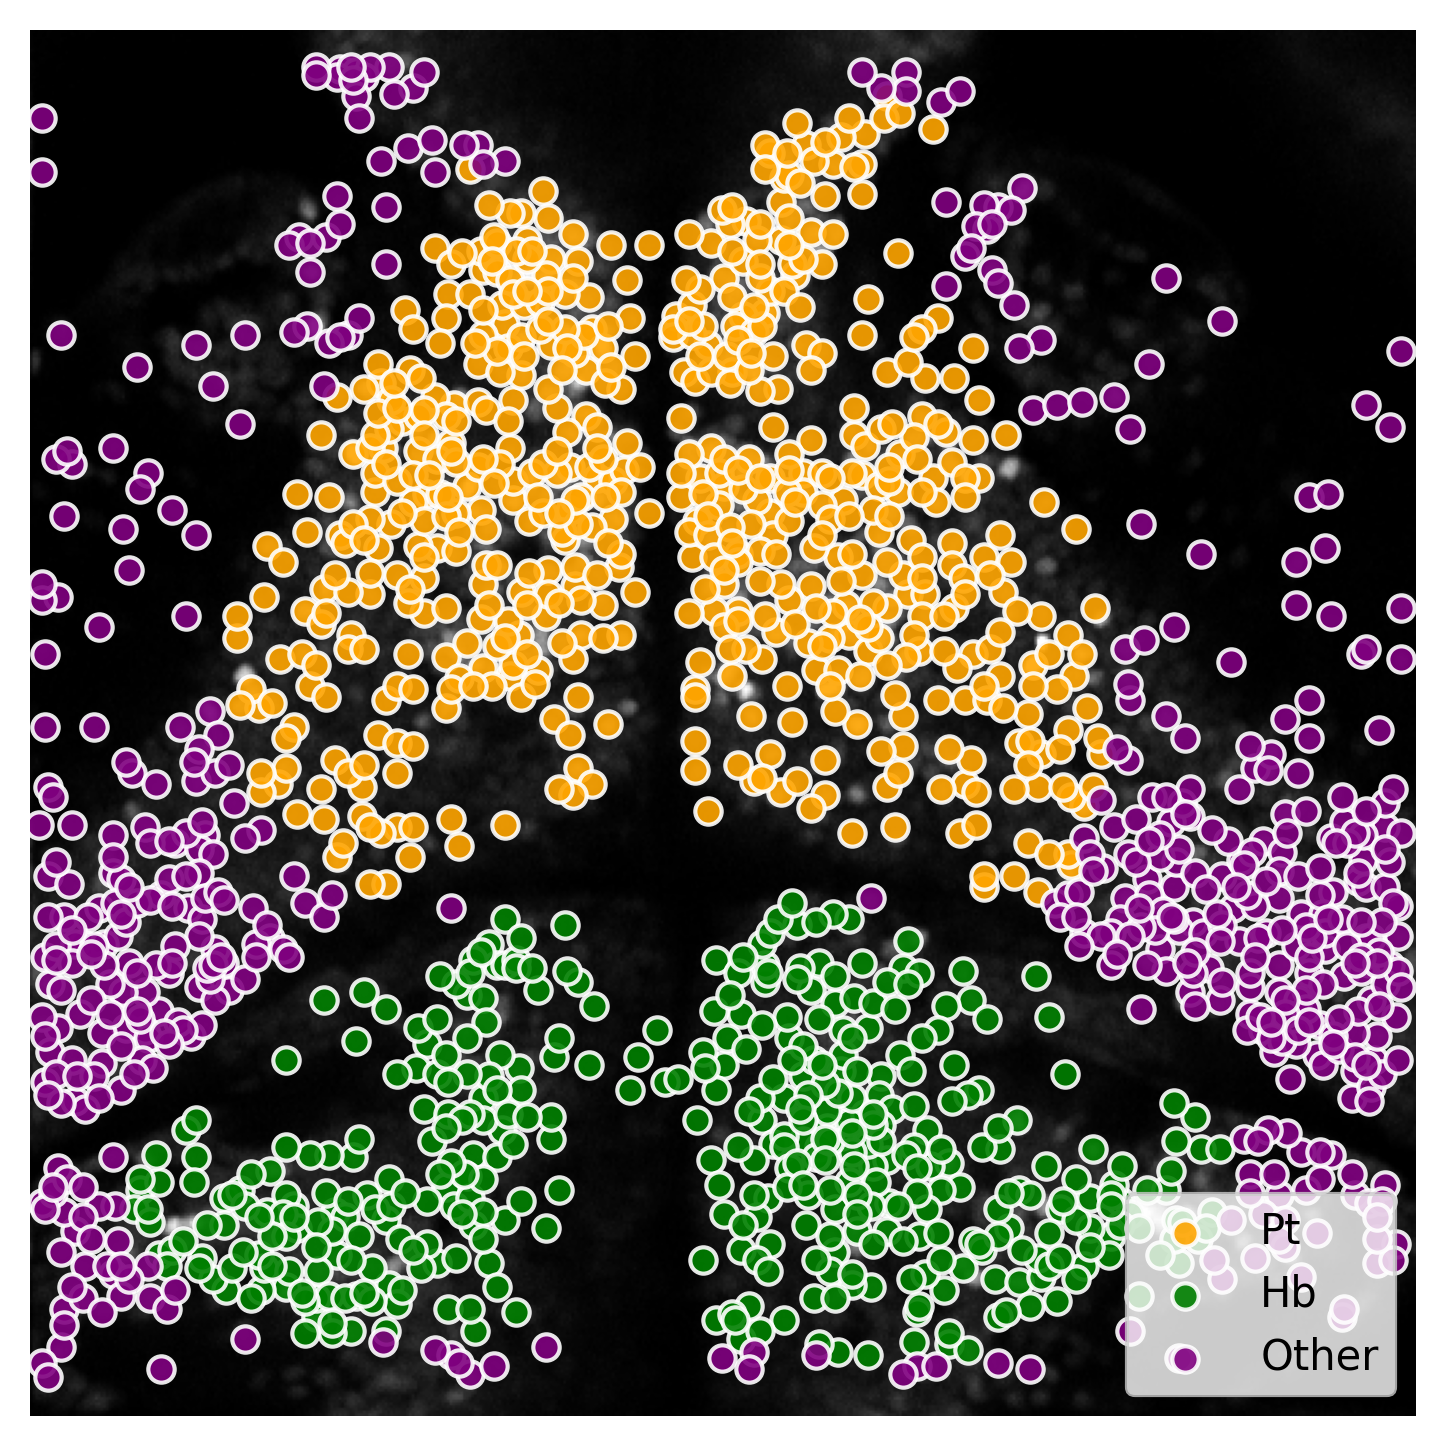

saved C:\Users\jacob\OneDrive\Documents\GitHub\results_temp_location\experiment_4\fig4b.pdf


In [140]:
import os
import glob
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile

fish = 11
COLOR_MAP = {"Pt": "orange", "Hb": "green", "Other": "purple"}

def bright_plane0(f, boost=1.5):
    pattern = os.path.join(img_dir, "plane_0.*")
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No files match {pattern!r}")
    plane0_path = files[0]
    im = tifffile.imread(plane0_path).astype(float)
    im = (im - im.min()) / (im.max() - im.min())
    return np.clip(im * boost, 0, 1)

def plane0_table(f):
    h5_path = os.path.normpath(
        os.path.join(
            DATA_DIR,
            f"fish{f}",
            "data",
            "functional_types_df.h5",
        )
    )
    df = pd.read_hdf(h5_path)
    return df[df.plane == "plane_0"]

df0 = plane0_table(fish).copy()
df0["coords"] = df0.neur_coords.apply(
    lambda v: ast.literal_eval(v) if isinstance(v, str) else v
)
df0["grp"] = df0.region.fillna("unknown").apply(
    lambda r: r if r in ("Pt", "Hb") else "Other"
)

bg = bright_plane0(fish)
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.imshow(bg, cmap="gray", vmin=0, vmax=1)

for group, color in COLOR_MAP.items():
    coords_list = df0.loc[df0.grp == group, "coords"].tolist()
    if not coords_list:
        continue
    pts = np.vstack(coords_list)
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        s=40,
        c=color,
        edgecolors="white",
        alpha=0.9,
        label=group,
    )

ax.legend(loc="lower right")
ax.axis("off")

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

out = os.path.join(BASE_DIR, f"fig4b.pdf")
fig.savefig(out, bbox_inches="tight", transparent=True)
plt.show()
plt.close(fig)
print("saved", out)

## Figure 5

## Figure 6